In [3]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Found 188 CSV files


Loading datasets:  12%|█▏        | 23/188 [00:00<00:02, 64.48it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-07-29--11-17-20_4.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-07-29--12-02-42_28.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-07-29--12-02-42_30.csv


Loading datasets:  19%|█▉        | 36/188 [00:00<00:03, 49.26it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-07-29--16-37-17_5.csv


Loading datasets:  51%|█████     | 96/188 [00:02<00:02, 37.31it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-08-03--10-35-16_14.csv


Loading datasets:  56%|█████▌    | 105/188 [00:02<00:01, 42.96it/s]



Dataset sizes:
Total samples: 118865
Train: 83205 (70.0%)
Validation: 17830 (15.0%)
Test: 17830 (15.0%)

Visualizing sample datapoints from training set...


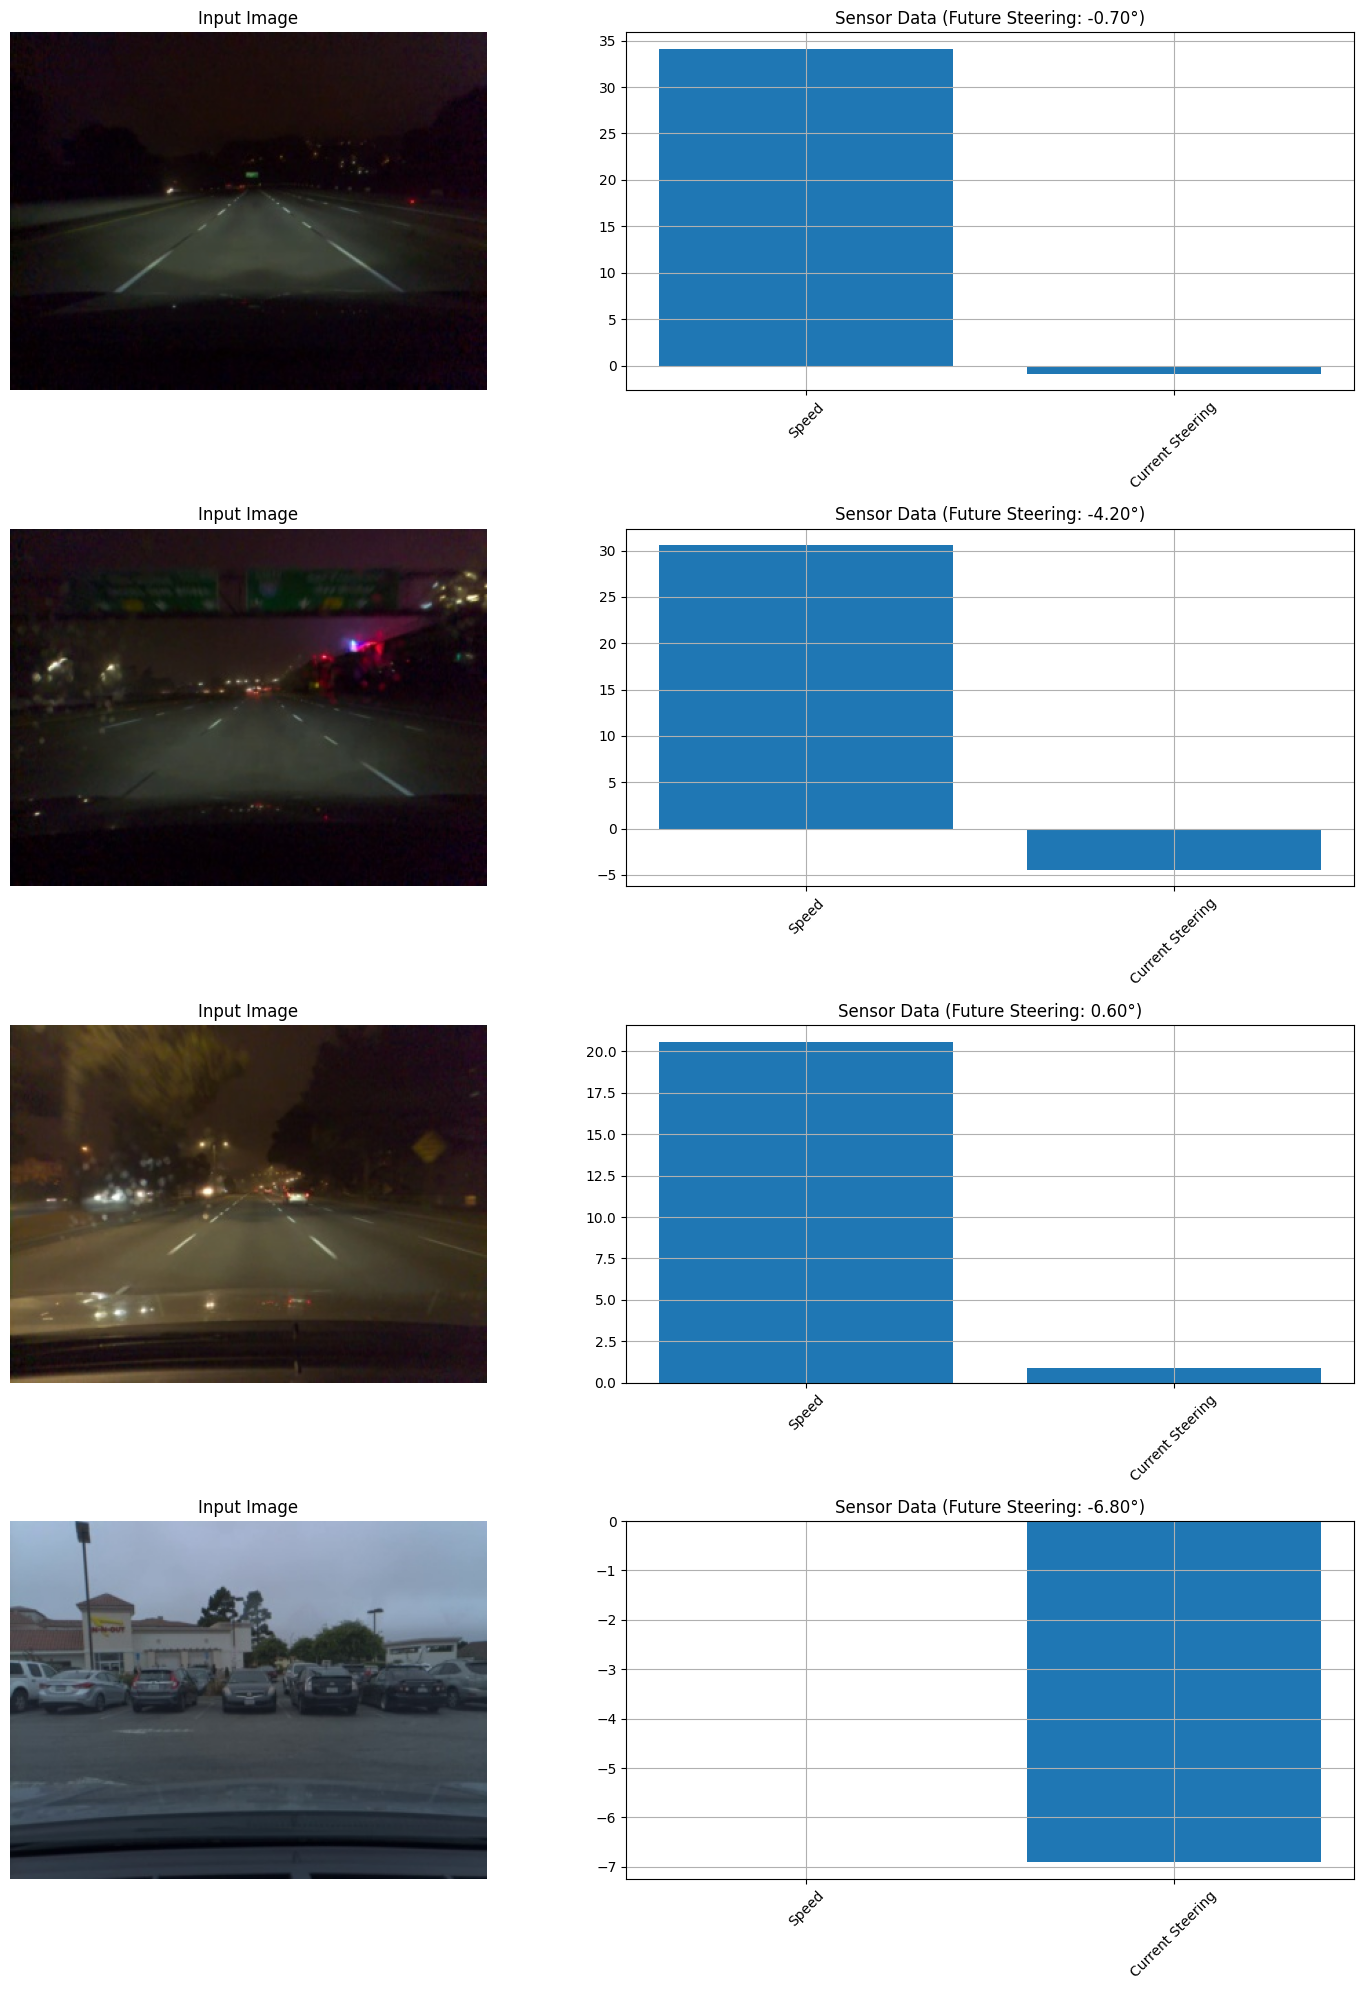

In [4]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class DrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(DATA_DIR, f"{filename[:-4]}_frames")
        
        #print(f"CSV file: {csv_file}")
        #print(f"Frames directory: {self.frames_dir}")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        frame = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
        
        # Add steering history to sensor data
        current_data = torch.tensor([
            speed_value,
            row['current_steering'],
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization with updated labels
        sensor_labels = [
            'Speed', 
            'Current Steering',
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
counter = 0
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        if (counter > 99):
            break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = DrivingDataset(csv_file)
        datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
total_len = len(full_dataset)
train_end = int(0.7 * total_len) # from 0.7 to 0.85
val_end = int(0.85 * total_len) # from 0.85 to 1

train_dataset = Subset(full_dataset, list(range(0, train_end))) # from 0 to 0.7
val_dataset = Subset(full_dataset, list(range(train_end, val_end))) # from 0.7 to 0.85
test_dataset = Subset(full_dataset, list(range(val_end, total_len))) # from 0.85 to 1

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.models as models
from torchvision.models import mobilenet_v2

class SteeringAngleCNN(nn.Module):
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()
        mobilenet = mobilenet_v2(pretrained=True)
        self.features = mobilenet.features  # Output shape: [B, 1280, H, W]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(1280 + 2, 128),  # 1 = speed + steering angle
            nn.ReLU(),
            nn.Linear(128, 1)          # Predict next steering angle
        )

    def forward(self, image, sensor_data):
        x = self.features(image)            # [B, 1280, H, W]
        x = self.pool(x).view(x.size(0), -1)  # [B, 1280]
        x = torch.cat([x, sensor_data], dim=1)  # [B, 1282]
        return self.fc(x)

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print ("running loss:", running_loss, "length val loader:", len(val_loader.dataset))
        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

In [7]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[1000:1400], label='Future Ground Truth')
    plt.plot(all_preds[1000:1400], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

/home/chznight/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chznight/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Ti SUPER
Device memory: 17.17 GB
Training on cuda:0


Epoch 1/10: 100%|██████████| 1301/1301 [03:15<00:00,  6.65it/s, loss=0.0235]


running loss: 11386.501789987087 length val loader: 17830
Epoch 1: Train Loss: 1.7344, Val Loss: 0.6386


Epoch 2/10: 100%|██████████| 1301/1301 [03:15<00:00,  6.66it/s, loss=0.115]


running loss: 14257.471321702003 length val loader: 17830
Epoch 2: Train Loss: 0.6768, Val Loss: 0.7996


Epoch 3/10: 100%|██████████| 1301/1301 [03:12<00:00,  6.75it/s, loss=0.995]


running loss: 11046.155045814812 length val loader: 17830
Epoch 3: Train Loss: 0.6153, Val Loss: 0.6195


Epoch 4/10: 100%|██████████| 1301/1301 [03:15<00:00,  6.66it/s, loss=1.4]  


running loss: 14841.242196969688 length val loader: 17830
Epoch 4: Train Loss: 0.6220, Val Loss: 0.8324


Epoch 5/10: 100%|██████████| 1301/1301 [03:16<00:00,  6.63it/s, loss=1.01]  


running loss: 11945.788416266441 length val loader: 17830
Epoch 5: Train Loss: 0.5418, Val Loss: 0.6700


Epoch 6/10: 100%|██████████| 1301/1301 [03:13<00:00,  6.72it/s, loss=0.464]


running loss: 12268.725131079555 length val loader: 17830
Epoch 6: Train Loss: 0.4769, Val Loss: 0.6881


Epoch 7/10: 100%|██████████| 1301/1301 [03:14<00:00,  6.68it/s, loss=0.192]


running loss: 11088.665717549622 length val loader: 17830
Epoch 7: Train Loss: 0.4289, Val Loss: 0.6219


Epoch 8/10: 100%|██████████| 1301/1301 [03:13<00:00,  6.73it/s, loss=5.41] 


running loss: 15843.749478437006 length val loader: 17830
Epoch 8: Train Loss: 0.3864, Val Loss: 0.8886


Epoch 9/10: 100%|██████████| 1301/1301 [03:11<00:00,  6.80it/s, loss=0.0863]


running loss: 14100.234559178352 length val loader: 17830
Epoch 9: Train Loss: 0.3734, Val Loss: 0.7908
Early stopping triggered at epoch 9


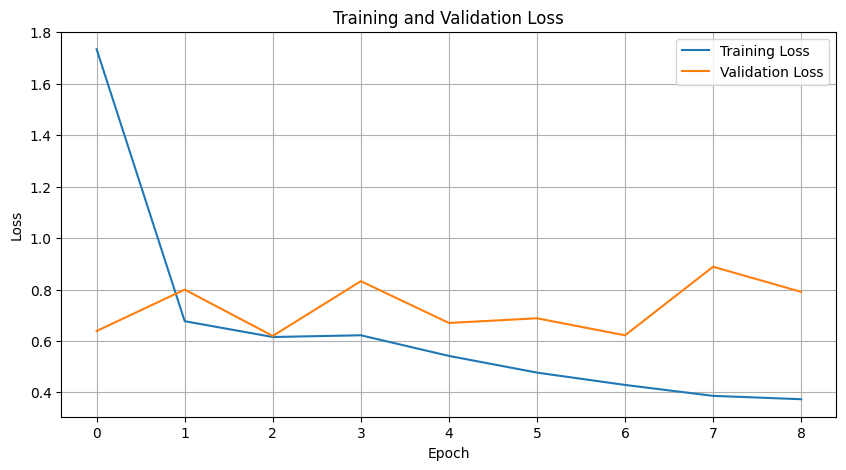


Model saved to 'v4_CNN2.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.9494 degrees²
MAE: 0.5714 degrees
Predictions within 1°: 85.9%
Predictions within 3°: 98.9%
Predictions within 5°: 99.6%


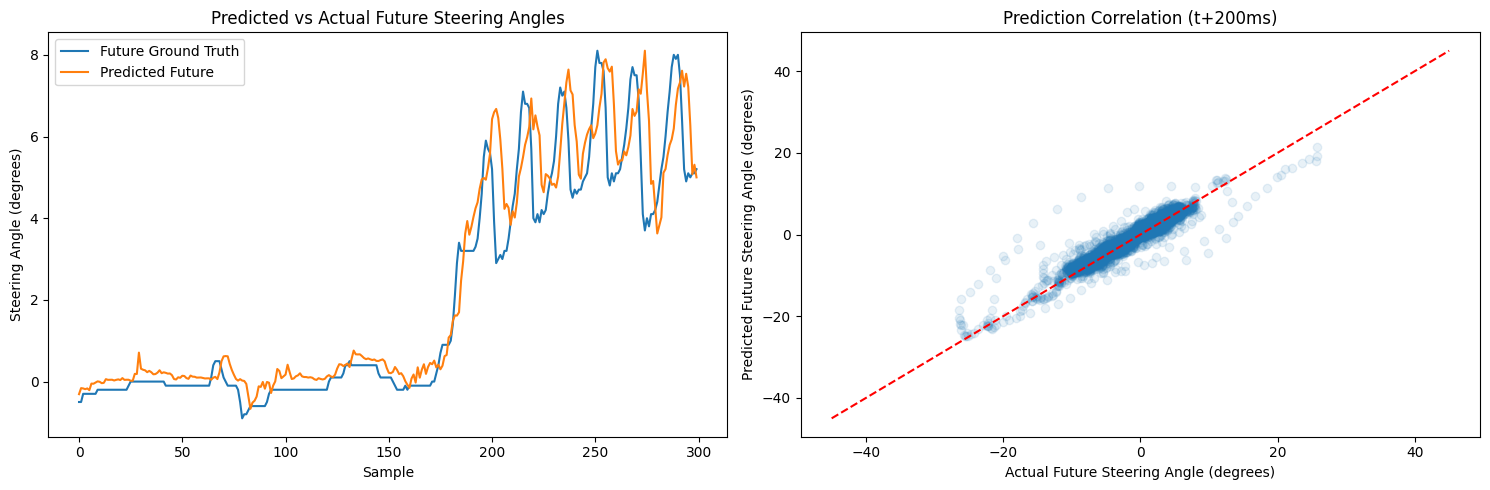


Visualizing some predictions...


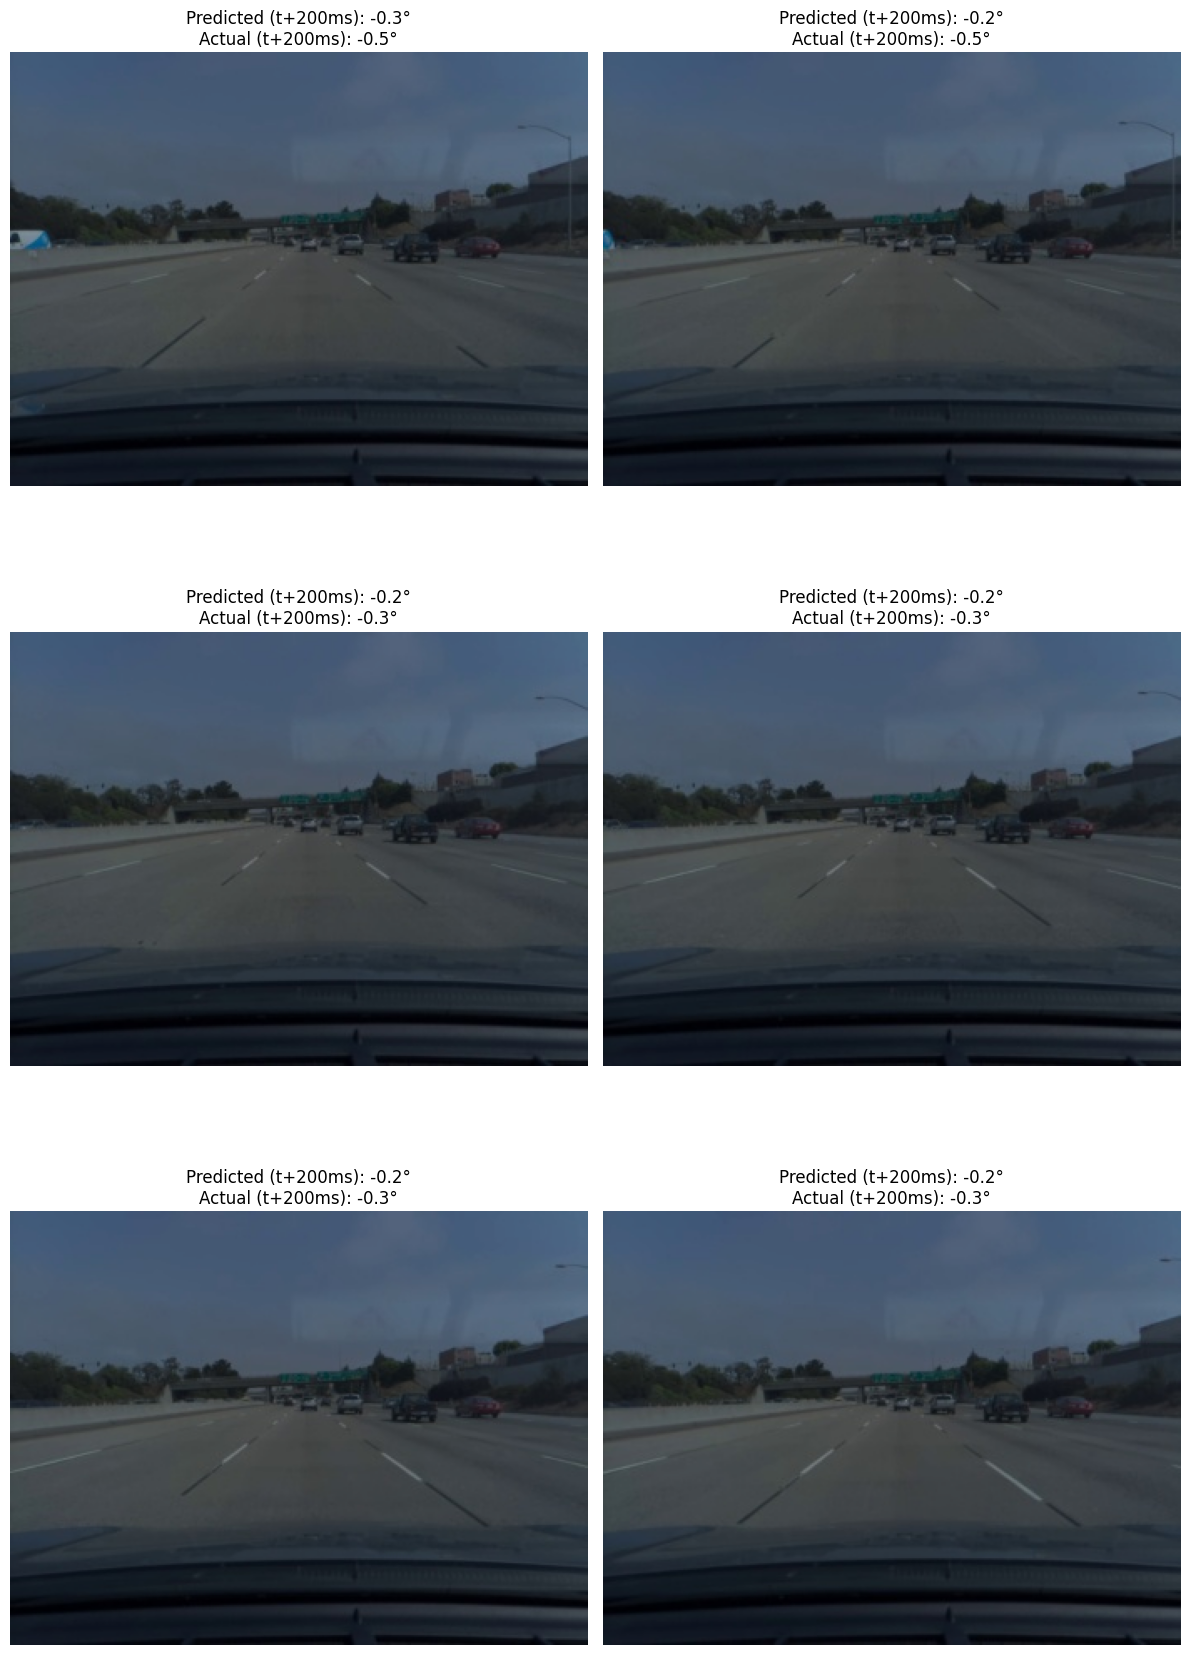

In [ ]:
# Initialize and train
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    patience=6
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN_MobileNetV2.pth')
print("\nModel saved to 'v4_CNN_MobileNetV2.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)

/home/chznight/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chznight/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1555243/3867064063.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY


Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.9494 degrees²
MAE: 0.5714 degrees
Predictions within 1°: 85.9%
Predictions within 3°: 98.9%
Predictions within 5°: 99.6%


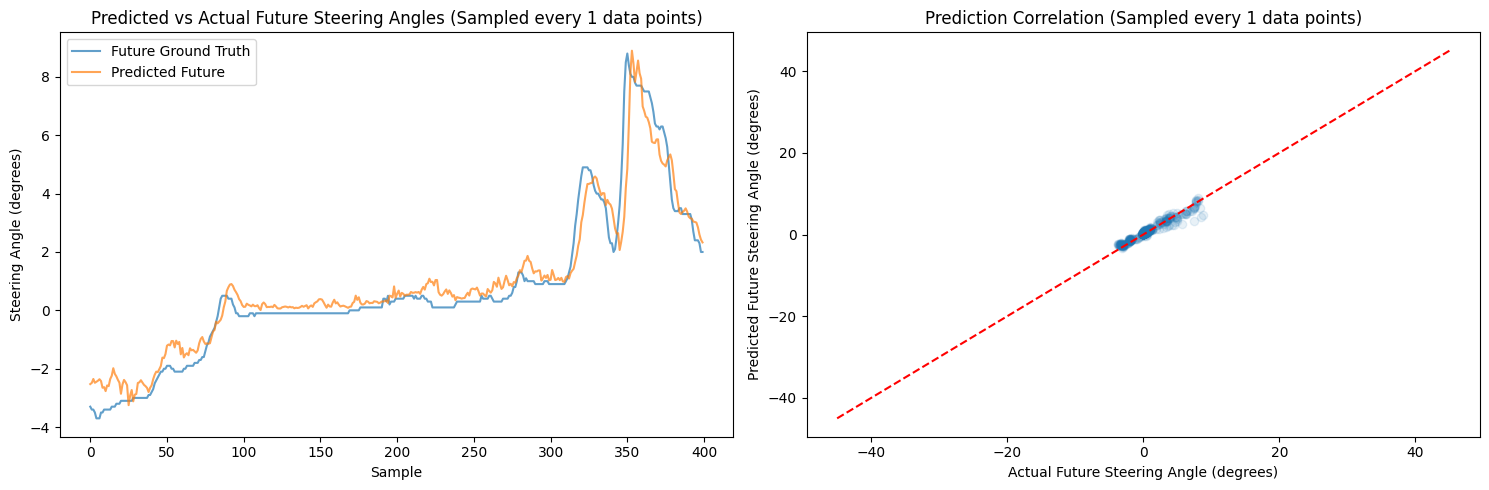

In [11]:
def test_model_with_sample_rate(model, test_loader, sample_rate=1):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Sample every 'sample_rate' points for visualization
    sampled_preds = all_preds[::sample_rate]
    sampled_targets = all_targets[::sample_rate]
    sampled_preds = all_preds[1000:1400]
    sampled_targets = all_targets[1000:1400]

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth (with sampled data points)
    plt.subplot(1, 2, 1)
    plt.plot(sampled_targets, label='Future Ground Truth', alpha=0.7)
    plt.plot(sampled_preds, label='Predicted Future', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title(f'Predicted vs Actual Future Steering Angles (Sampled every {sample_rate} data points)')
    plt.legend()

    # Correlation plot (with sampled data points)
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_targets, sampled_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title(f'Prediction Correlation (Sampled every {sample_rate} data points)')

    plt.tight_layout()
    plt.show()

model = SteeringAngleCNN()
model.load_state_dict(torch.load('v4_CNN_MobileNetV2.pth'))

test_model_with_sample_rate(model, test_loader, sample_rate=1)


Visualizing most incorrect predictions across batches...


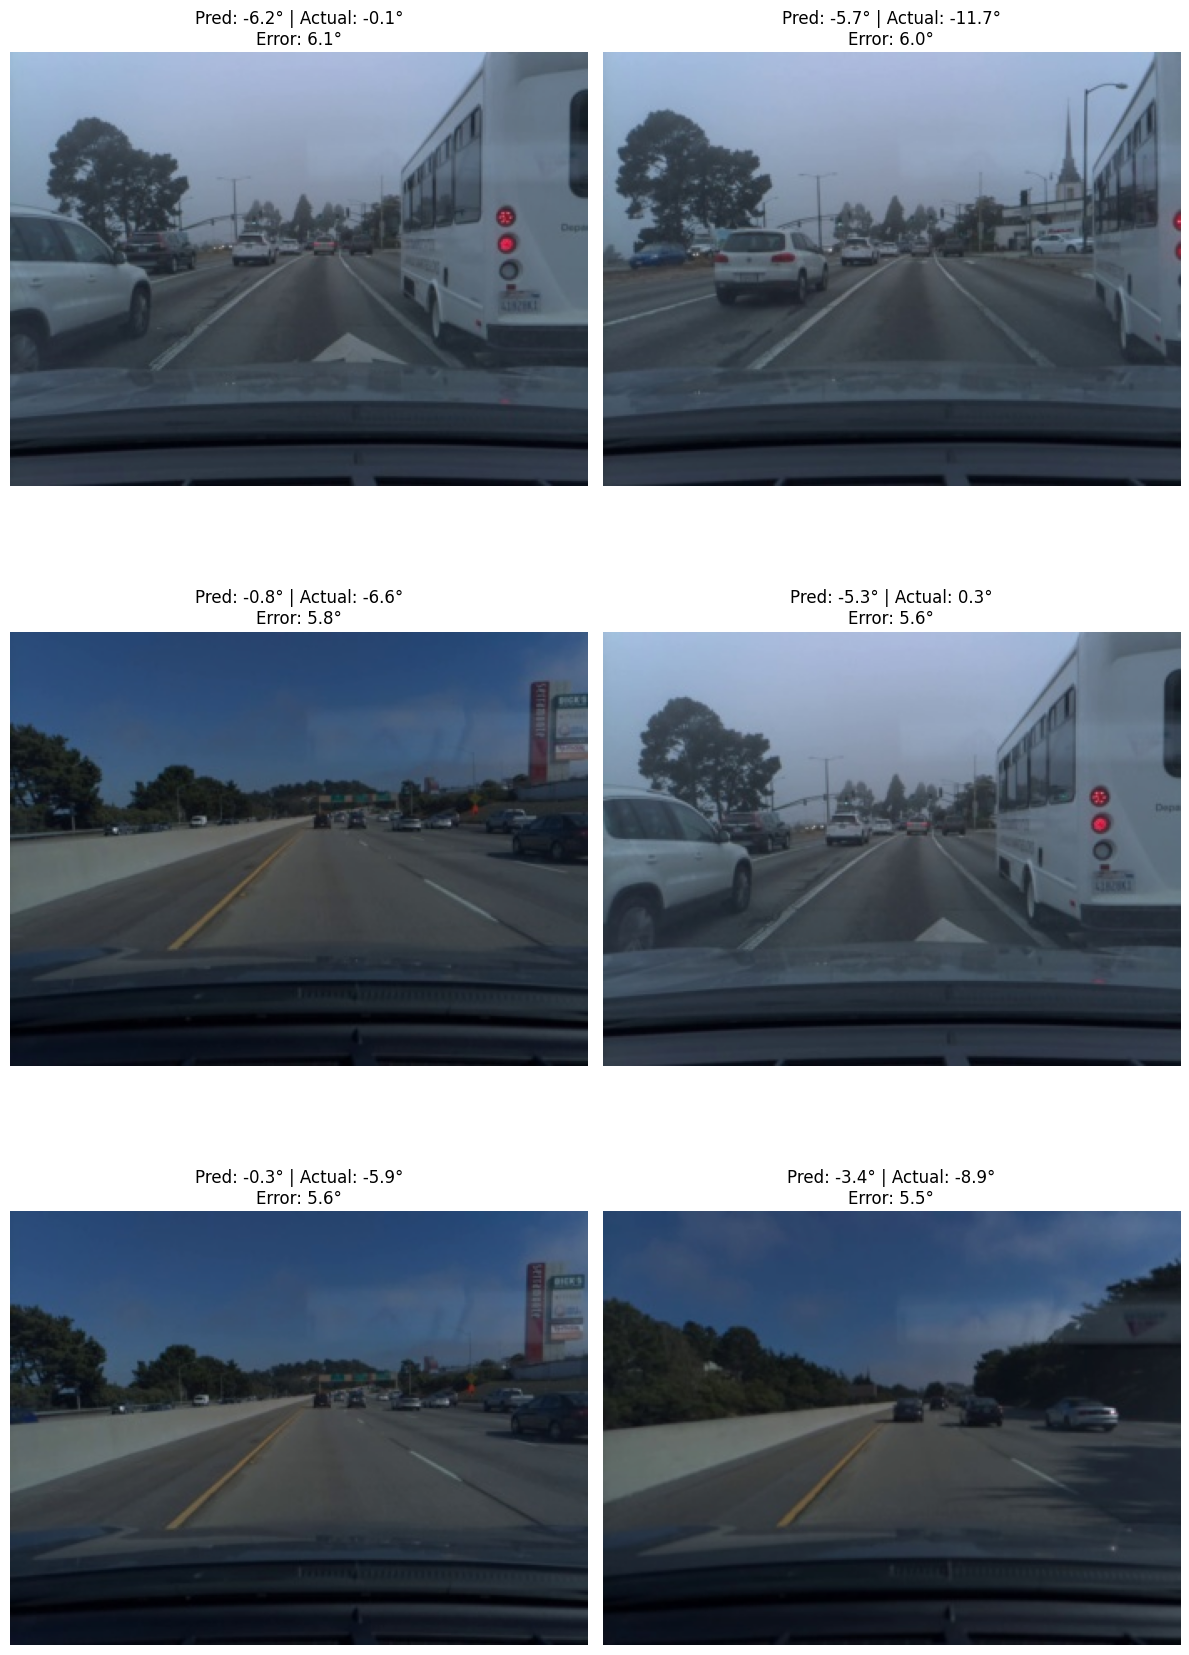

In [8]:
def visualize_most_wrong_predictions_all_batches(model, test_loader, max_batches=80):
    model.eval()
    device = next(model.parameters()).device

    all_images = []
    all_predictions = []
    all_targets = []
    all_errors = []

    with torch.no_grad():
        for batch_idx, (images, sensor_data, targets) in enumerate(test_loader):
            if batch_idx >= max_batches:
                break

            images = images.to(device)
            sensor_data = sensor_data.to(device)

            preds = model(images, sensor_data)

            # Move to CPU
            preds = preds.cpu().numpy().squeeze()
            targs = targets.numpy().squeeze()
            imgs = images.cpu().numpy()

            # Compute errors
            errors = np.abs(preds - targs)

            all_images.extend(imgs)
            all_predictions.extend(preds)
            all_targets.extend(targs)
            all_errors.extend(errors)

    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_errors = np.array(all_errors)

    # Get top 6 most wrong predictions
    top_indices = np.argsort(all_errors)[-6:][::-1]

    # Plot those images
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for idx, ax in zip(top_indices, axes.flat):
        img = all_images[idx].transpose(1, 2, 0)

        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(
            f'Pred: {all_predictions[idx]:.1f}° | Actual: {all_targets[idx]:.1f}°\nError: {all_errors[idx]:.1f}°'
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing most incorrect predictions across batches...")
visualize_most_wrong_predictions_all_batches(model, val_loader, max_batches=80)
